In [1]:
!pip install tensorflow

In [2]:

import numpy as np
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

file_path = "Sherlock Holmes.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

text_data = text_data.lower()
text_data = re.sub(r'[^a-zA-Z0-9\s]', '', text_data)

sentences = text_data.split("\n")[:8500]


In [3]:
tokenizer = Tokenizer(oov_token="<oov>")
tokenizer.fit_on_texts(sentences)

word_sequences = tokenizer.texts_to_sequences(sentences)

total_words = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {total_words}")


Vocabulary Size: 7045



📊 EDA Summary
Total characters: 587902
Total sentences: 8500
Total words: 104521
Average sentence length: 8.49 words

Top 20 Most Common Words:
the: 5621
and: 3002
i: 2994
to: 2685
of: 2658
a: 2626
in: 1758
that: 1735
it: 1697
you: 1477
he: 1463
was: 1409
his: 1159
is: 1123
my: 1006
have: 922
as: 852
with: 830
had: 829
which: 769


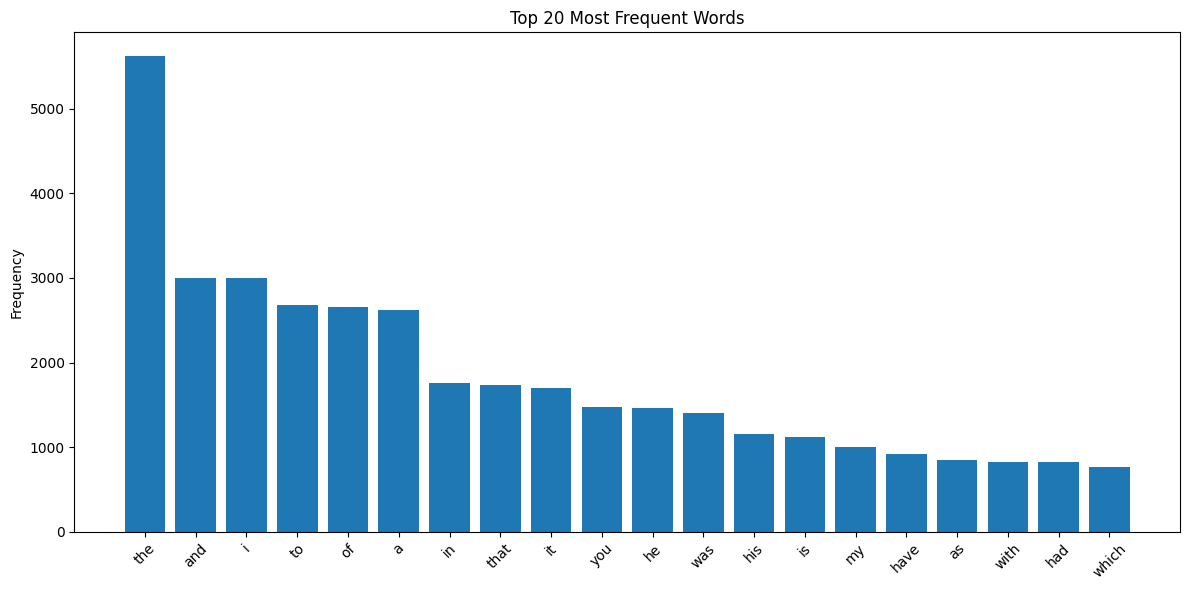

In [4]:
# 📊 Step 1.5: Exploratory Data Analysis (EDA)
print("\n📊 EDA Summary")
print(f"Total characters: {len(text_data)}")
print(f"Total sentences: {len(sentences)}")
word_list = text_data.split()
print(f"Total words: {len(word_list)}")
avg_sentence_length = sum(len(s.split()) for s in sentences) / len(sentences)
print(f"Average sentence length: {avg_sentence_length:.2f} words")

# Frequency distribution
word_freq = Counter(word_list)
most_common_words = word_freq.most_common(20)
print("\nTop 20 Most Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

# 📈 Plot: Top 20 Words
plt.figure(figsize=(12, 6))
words, freqs = zip(*most_common_words)
plt.bar(words, freqs)
plt.title("Top 20 Most Frequent Words")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

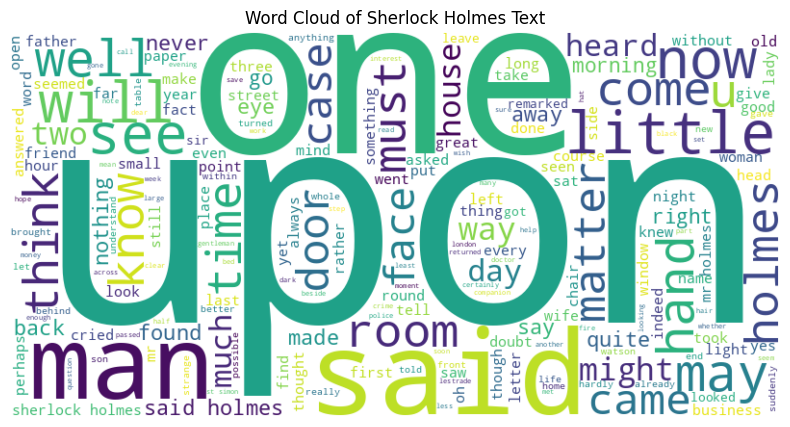

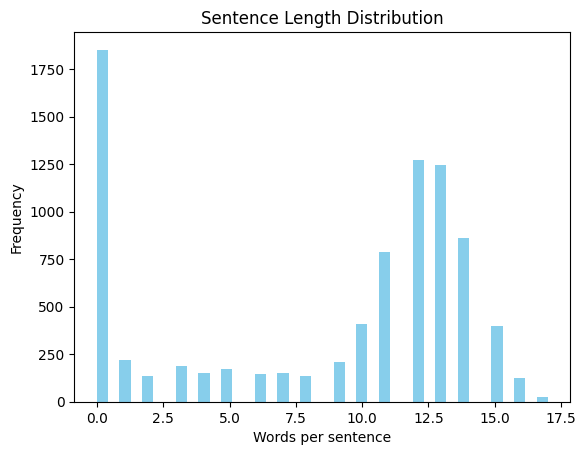

In [5]:
# ☁️ WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(word_list))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Sherlock Holmes Text")
plt.show()

# 📊 Sentence Length Distribution
sentence_lengths = [len(s.split()) for s in sentences]
plt.hist(sentence_lengths, bins=40, color='skyblue')
plt.title("Sentence Length Distribution")
plt.xlabel("Words per sentence")
plt.ylabel("Frequency")
plt.show()

In [6]:
window_size = 5
input_sequences = []

for seq in word_sequences:
    if len(seq) < 2:
        continue

    for i in range(len(seq) - window_size):
        n_gram_sequence = seq[i : i + window_size]
        input_sequences.append(n_gram_sequence)


input_sequences = np.array(input_sequences)

xs, labels = input_sequences[:, :-1], input_sequences[:, -1]


max_sequence_len = xs.shape[1]
xs = pad_sequences(xs, maxlen=max_sequence_len, padding="pre")

ys = tf.keras.utils.to_categorical(labels.reshape(-1, 1), num_classes=total_words)

max_sequence_len = xs.shape[1]
xs = pad_sequences(xs, maxlen=max_sequence_len, padding="pre")

print(f"Input Shape: {xs.shape}")
print(f"Labels Shape: {ys.shape}")

Input Shape: (40766, 4)
Labels Shape: (40766, 7045)


In [7]:
model = Sequential([
    Embedding(total_words, 256, input_length=max_sequence_len-1),
    Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='glorot_uniform')),
    Dropout(0.3),
    Bidirectional(LSTM(256)),
    Dense(total_words, activation='softmax')
])

adam = Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy', TopKCategoricalAccuracy(k=5)]
)

epochs = 30
batch_size = 64

for epoch in range(epochs):
    history = model.fit(xs, ys, epochs=1, verbose=1, batch_size=batch_size)

    predictions = model.predict(xs, verbose=0)
    loss = tf.keras.losses.categorical_crossentropy(ys, predictions)
    perplexity = np.exp(np.mean(loss))

    accuracy = history.history["accuracy"][0]
    top5_accuracy = history.history["top_k_categorical_accuracy"][0]

    print(f"Epoch {epoch + 1}/{epochs} - Accuracy: {accuracy:.4f}, Top-5 Accuracy: {top5_accuracy:.4f}, Perplexity: {perplexity:.4f}")

model.save("sherlock_bilstm_model.h5")
print("Model saved successfully!")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


637/637 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.0547 - loss: 6.8044 - top_k_categorical_accuracy: 0.1669
Epoch 1/30 - Accuracy: 0.0610, Top-5 Accuracy: 0.1787, Perplexity: 343.0299
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.0892 - loss: 5.7418 - top_k_categorical_accuracy: 0.2379
Epoch 2/30 - Accuracy: 0.1002, Top-5 Accuracy: 0.2555, Perplexity: 186.1898
637/637 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.1311 - loss: 5.2133 - top_k_categorical_accuracy: 0.3033
Epoch 3/30 - Accuracy: 0.1314, Top-5 Accuracy: 0.3042, Perplexity: 118.4920
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1524 - loss: 4.8017 - top_k_categorical_accuracy: 0.3411
Epoch 4/30 - Accuracy: 0.1524, Top-5 Accuracy: 0.3410, Perplexity: 72.7280
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1816 - loss: 4.3422 - top_k_categorical_accuracy: 0.3869
Epoch 5/30 - Accuracy: 0.1780, Top-5 Accuracy: 0.3786, Perplexity: 42.1127
637/637 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accurac

Epoch 30/30 - Accuracy: 0.9613, Top-5 Accuracy: 0.9977, Perplexity: 1.0870
Model saved successfully!


In [8]:
def predict_next_words(model, tokenizer, input_text, k=3):
    sequence = tokenizer.texts_to_sequences([input_text])
    padded_seq = pad_sequences(sequence, maxlen=max_sequence_len-1, padding='pre')

    predictions = model.predict(padded_seq)[0]
    top_k_indices = tf.math.top_k(predictions, k=k).indices.numpy()
    top_k_words = [tokenizer.index_word[i] for i in top_k_indices if i in tokenizer.index_word]

    return top_k_words

test_sentence = "They are waiting for"
print(f"Predicted words: {predict_next_words(model, tokenizer, test_sentence, k=3)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Predicted words: ['the', 'us', 'you']


In [28]:
def predict_next_phrase(seed_text, num_words=3):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_word_index = np.argsort(predicted_probs[0])[-3:][::-1]
        predicted_words = [tokenizer.index_word[idx] for idx in predicted_word_index if idx in tokenizer.index_word]
        seed_text += ' ' + predicted_words[0]
    return seed_text

In [64]:

p1 = predict_next_phrase("but")
print(p1)
p2 = predict_next_phrase(p1)
print(p2)
p3 = predict_next_phrase(p2)
print(p3)
p4 = predict_next_phrase(p3)
print(p4)
p5 = predict_next_phrase(p4)
print(p5)


but i have heard
but i have heard him in many
but i have heard him in many years you have
but i have heard him in many years you have the main facts
but i have heard him in many years you have the main facts of the room
